# Use Google Colab, if running in mac m1

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
print(tf.__version__)
print(np.__version__)

2.4.0-rc0
1.21.2


<PrefetchDataset shapes: ((None, None), (None,)), types: (tf.float64, tf.float64)>


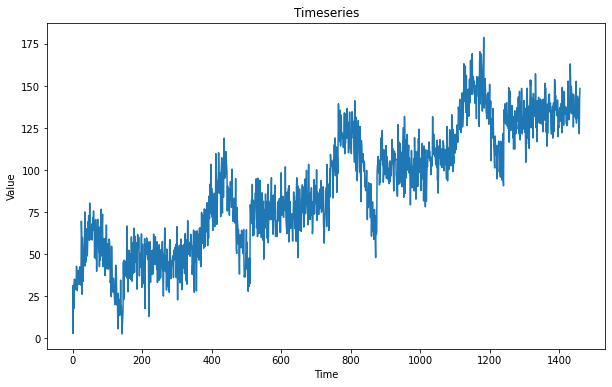

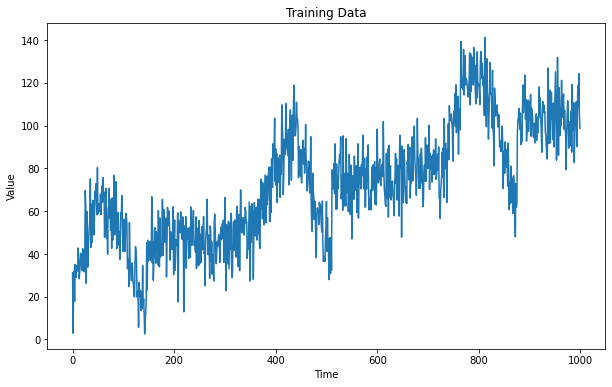

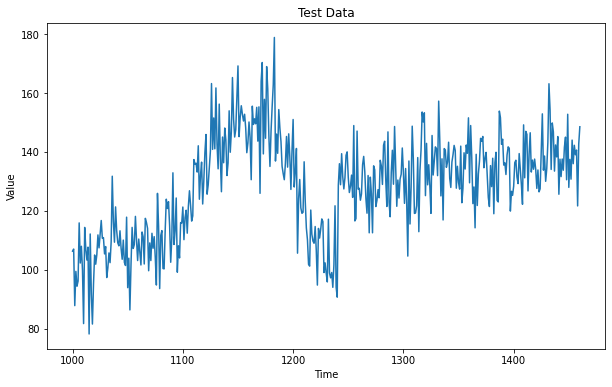

In [2]:
def trend(time, slope):
    return time * slope
def seasonal_pattern(season_time):
    return np.where(season_time < 0.4, np.sin(3 * np.pi * season_time), 1/np.exp(3 * season_time))
def seasonality(time, period, amplitude, phase=0):
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)
def noise(time, noise_level=10, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level
def plot_series(time, series, title=None):
    plt.figure(figsize=(10, 6))
    plt.plot(time, series)
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.title(title)
@tf.autograph.experimental.do_not_convert
def windowed_dataset(series, window_size, batch_size, shuffle_buffer=None):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(size=window_size+1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window : window.batch(window_size+1))
    dataset = dataset.map(lambda window: (window[:-1], window[-1])).shuffle(shuffle_buffer)
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset



baseline = 20
slope = 0.08
period = 365
amplitude = 40
noise_level = 10
seed = 50


time = np.arange(4 * 365 + 1)
series = baseline + trend(time, slope) + seasonality(time, period, amplitude) + noise(time, noise_level)

plot_series(time, series, 'Timeseries')

split_time = 1000

train_X = time[:split_time]
train_y = series[:split_time]
test_X = time[split_time:]
test_y = series[split_time:]
plot_series(train_X, train_y, 'Training Data')
plot_series(test_X, test_y, 'Test Data')

window_size = 20
batch_size = 32
shuffle_buffer = 1000

dataset = windowed_dataset(train_y, window_size, batch_size, shuffle_buffer)
print(dataset)



In [2]:
tf.keras.backend.clear_session()
tf.random.set_seed(50)
np.random.seed(50)

model = tf.keras.models.Sequential(layers=[
    tf.keras.layers.Lambda(lambda x : tf.expand_dims(x, axis=-1), input_shape=[None] ),
    tf.keras.layers.SimpleRNN(40, return_sequences=True),
    tf.keras.layers.SimpleRNN(40),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x : x * 100.0)
])
lr = 1e-10
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch : lr * 10**(epoch/20))
optimizer = tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.9)

model.compile(optimizer=optimizer, loss=tf.keras.losses.Huber(), metrics=['mae'])
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])

NotImplementedError: Cannot convert a symbolic Tensor (simple_rnn/strided_slice:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported

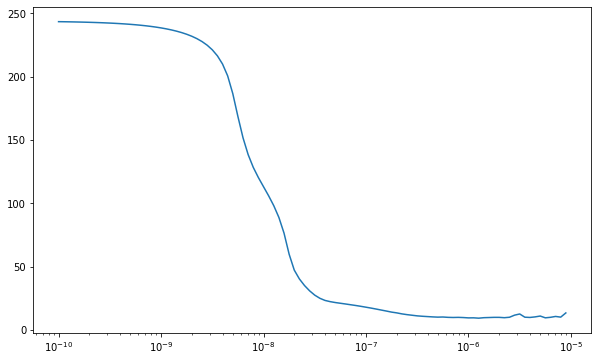

In [10]:
lr = history.history['lr']
loss = history.history['loss']
plt.figure(figsize=(10, 6))
plt.semilogx(lr, loss)

In [24]:
tf.keras.backend.clear_session()
tf.random.set_seed(50)
np.random.seed(50)

model = tf.keras.models.Sequential(layers=[
    tf.keras.layers.Lambda(lambda x : tf.expand_dims(x, axis=-1), input_shape=[None] ),
    tf.keras.layers.SimpleRNN(40, return_sequences=True),
    tf.keras.layers.SimpleRNN(40),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x : x * 100.0)
])
lr = 1e-8
optimizer = tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.9)

model.compile(optimizer=optimizer, loss=tf.keras.losses.Huber(), metrics=['mae'])
model.fit(dataset, epochs=1200)

Epoch 1/1200
31/31 [==============================] - 2s 9ms/step - loss: 241.5839 - mae: 242.0839
Epoch 2/1200
31/31 [==============================] - 0s 10ms/step - loss: 235.2765 - mae: 235.7765
Epoch 3/1200
31/31 [==============================] - 0s 10ms/step - loss: 226.4862 - mae: 226.9862
Epoch 4/1200
31/31 [==============================] - 0s 9ms/step - loss: 213.4577 - mae: 213.9577
Epoch 5/1200
31/31 [==============================] - 0s 9ms/step - loss: 191.3680 - mae: 191.8680
Epoch 6/1200
31/31 [==============================] - 0s 9ms/step - loss: 159.7090 - mae: 160.2090
Epoch 7/1200
31/31 [==============================] - 0s 9ms/step - loss: 136.7875 - mae: 137.2876
Epoch 8/1200
31/31 [==============================] - 0s 10ms/step - loss: 123.8009 - mae: 124.3009
Epoch 9/1200
31/31 [==============================] - 0s 9ms/step - loss: 115.0682 - mae: 115.5682
Epoch 10/1200
31/31 [==============================] - 0s 9ms/step - loss: 107.8802 - mae: 108.3802
Epoch 

In [ ]:
forecast=[]
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))


MAE : 11.397912979125977, MSE : 204.46768188476562


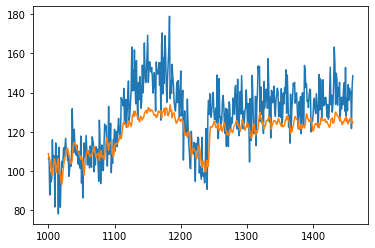

<Figure size 1728x864 with 0 Axes>

In [31]:
plt.plot(test_X, test_y)
plt.plot(test_X, results)
plt.figure(figsize=(24, 12))
print('MAE : {}, MSE : {}'.format(tf.keras.metrics.mean_absolute_error(test_y, results), tf.keras.metrics.mean_squared_error(test_y, results)))

In [27]:
forecast=[]
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

(1441,)
MAE :  tf.Tensor(10.024091810178543, shape=(), dtype=float64)


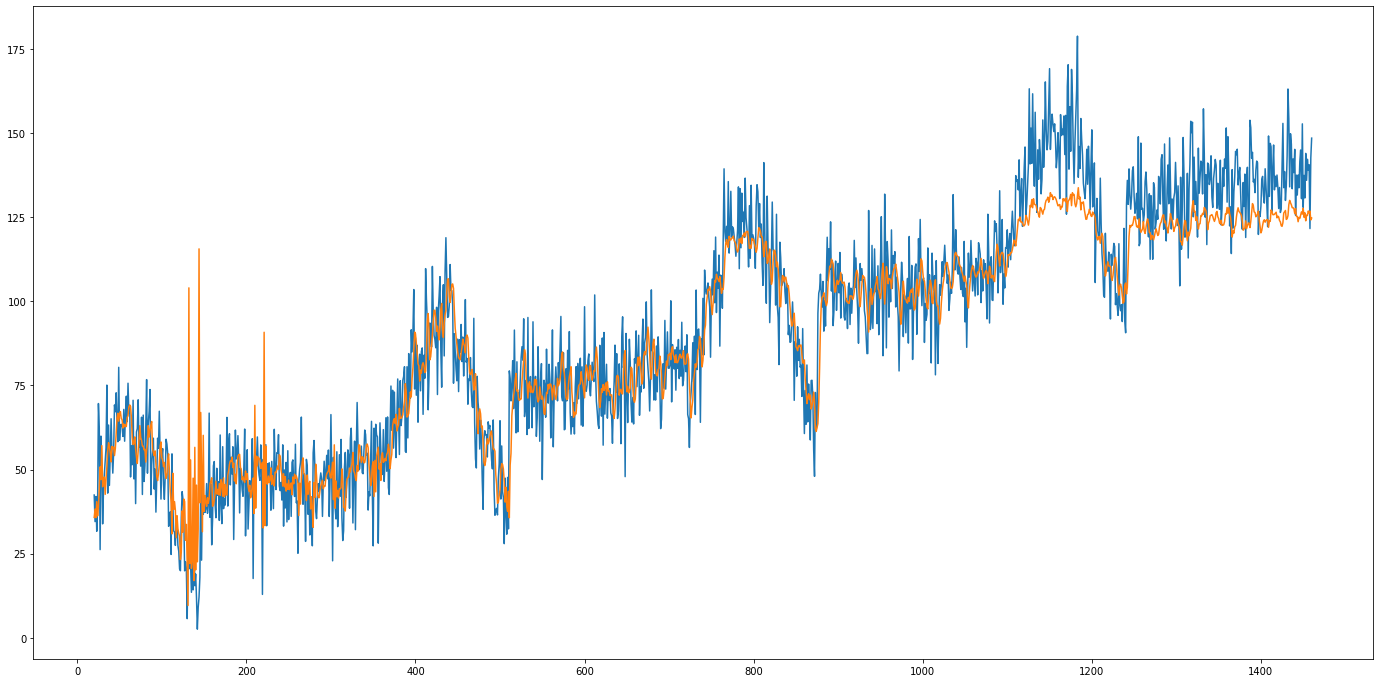

In [29]:
result = np.array(forecast)[:, 0, 0]
time = np.arange(4*365+1)
np_time = np.array(time)
print(result.shape)
time = time[window_size:]
plt.figure(figsize=(24, 12))
plt.plot(time, series[window_size:])
plt.plot(time, result)
print('MAE : ', tf.keras.metrics.mean_absolute_error(result, series[window_size:]))